In [12]:
# Installations
# import contextlib
# import io

# with contextlib.redirect_stdout(io.StringIO()): #suppress output (cleaner)
!pip install -q google-generativeai
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.86.1-0ubuntu1.4).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [ ]:
# Imports (decide if all in one cell, or spread out)

In [2]:
# Defining structured output
import typing_extensions as typing
from typing import Literal

class InformationSegment(typing.TypedDict):
    contributing_information: str
    contributing_information_type: Literal["text", "diagram", "table"]

class Page(typing.TypedDict):
    manual_page_num: str
    image_file_name: str
    information_segements: list[InformationSegment]
    
class Response(typing.TypedDict):
    relevant_pages: list[Page]
    query_answer: str    

In [3]:
# Configure API keys
from kaggle_secrets import UserSecretsClient
import google.generativeai as genai

user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GOOGLE_API_KEY")
genai.configure(api_key=api_key)

In [8]:
# Convert PDF to images
from pdf2image import convert_from_path

pdf_path = '../input/manuals/manual_130.pdf'
# pdf_path = '/kaggle/input/manual-130-numbered-low/manual_130_numbered.pdf' # Evan, file not in path right now
pages = convert_from_path(pdf_path, )

In [31]:
# Function - adds numbers to images
from PIL import Image, ImageDraw, ImageFont

def add_page_numbers_to_images_preview(pages):
    """
    Adds page numbers to each image in the pages list and returns the modified images.
    
    Args:
        pages (list): List of PIL.Image objects representing the pages of a PDF.

    Returns:
        list: List of PIL.Image objects with page numbers added.
    """
    transformed_pages = []
    
    for i, page in enumerate(pages):  # Process only the first 3 pages for preview
        # Copy the original image to avoid modifying it in place
        modified_page = page.copy()
        
        # Ensure the image is in RGB mode
        if modified_page.mode != "RGB":
            modified_page = modified_page.convert("RGB")
        
        # Draw the page number on the image
        draw = ImageDraw.Draw(modified_page)
        
        # Use default font
        font = ImageFont.load_default()
        
        # Set the page number text
        page_number_text = f"PAGE {i + 1}"
        
        # Calculate the position for the bottom-right corner using font.getsize()
        x_position = modified_page.width - 5 - 10  # 10 pixels padding
        y_position = modified_page.height - 5 - 10
        
        # Add text to the image at the calculated position
        draw.text((x_position, y_position), page_number_text, fill="black", font=font)
        
        # Append the modified page
        transformed_pages.append(modified_page)
    
    return transformed_pages


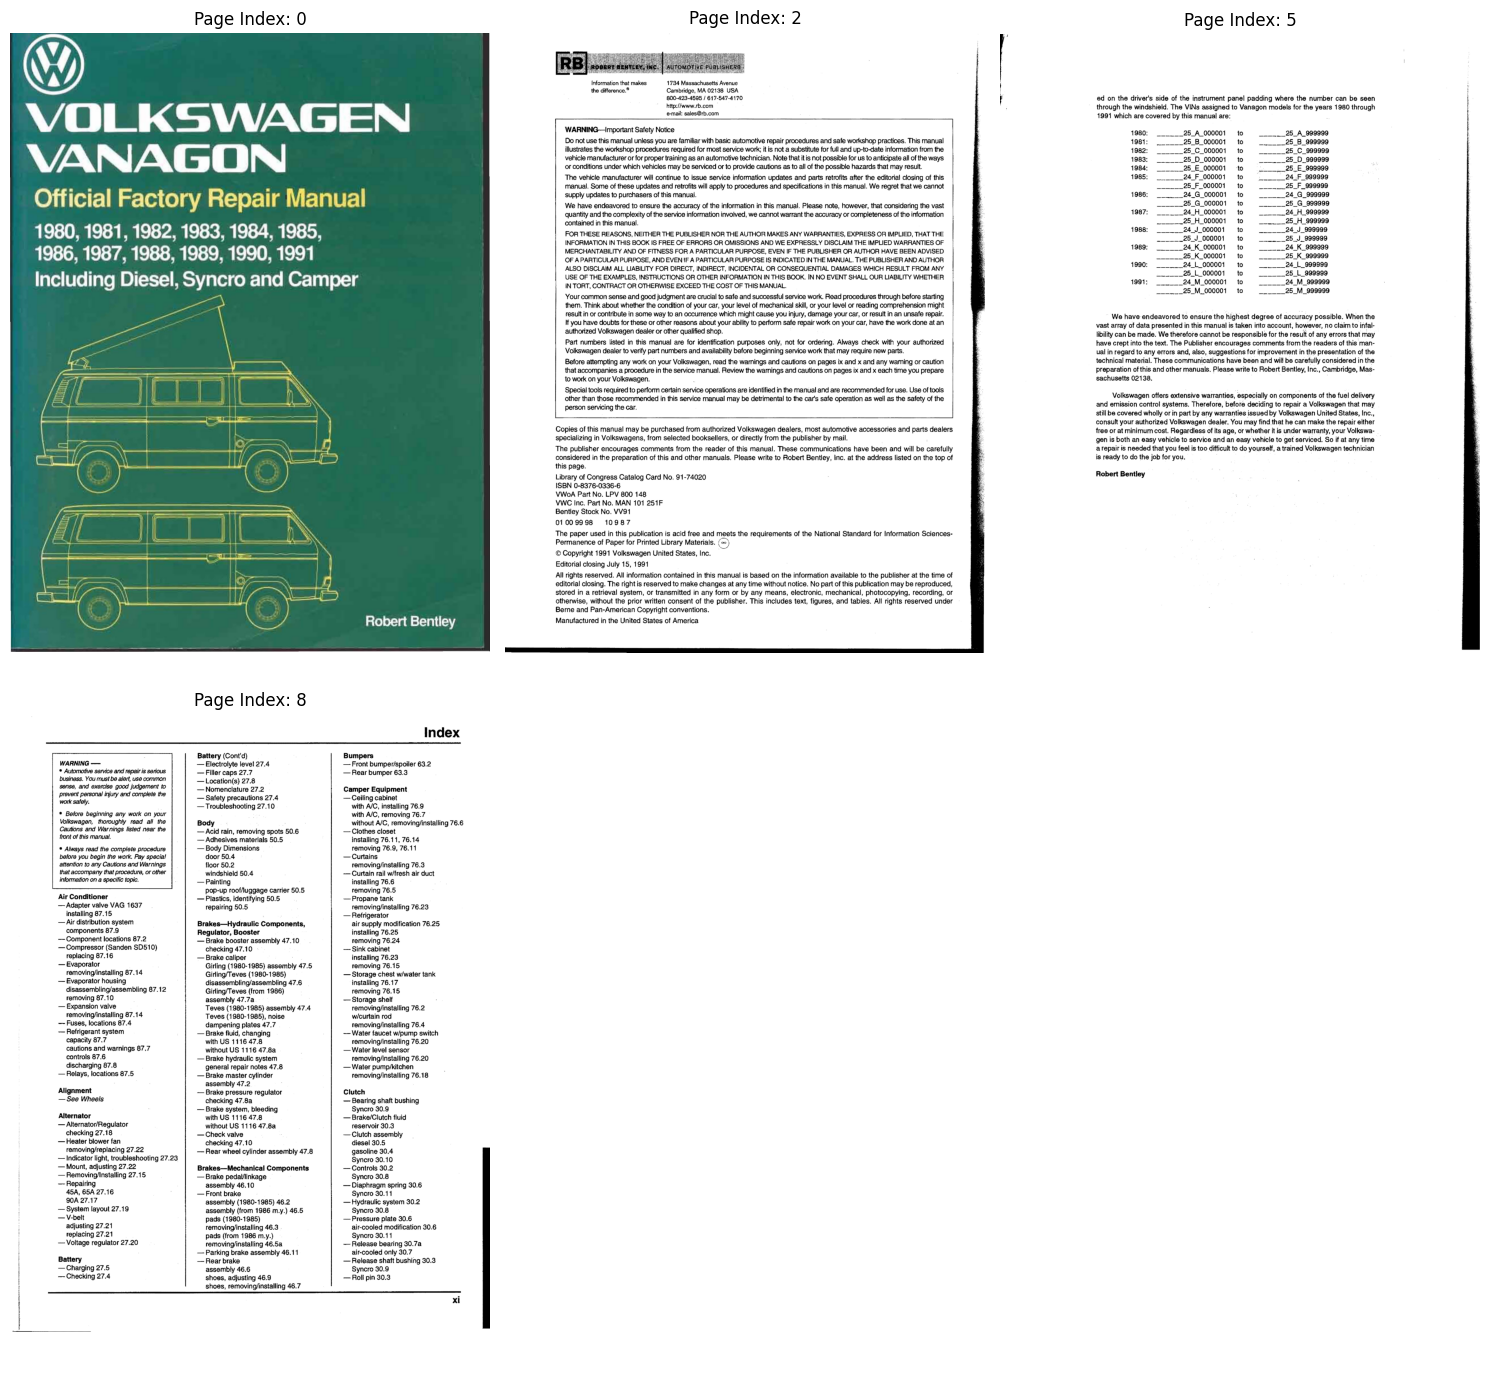

In [32]:
# Function - displays selected pages
from IPython.display import display
import matplotlib.pyplot as plt
import math

def display_selected_pages(pages, indexes, columns=2):
    """
    Displays specific pages based on their indexes, arranged in a grid with a configurable number of columns.
    
    Args:
        pages (list): List of PIL.Image objects representing the pages of a PDF.
        indexes (list): List of integers representing the indexes of pages to display.
        columns (int): Number of columns per row (default is 2).
    """
    # Validate columns
    if columns < 1:
        raise ValueError("The number of columns must be at least 1.")
    
    # Filter valid indexes
    valid_indexes = [index for index in indexes if 0 <= index < len(pages)]
    if len(valid_indexes) < len(indexes):
        print(f"Some indexes are invalid and have been skipped: {set(indexes) - set(valid_indexes)}")
    
    # Calculate rows needed
    rows = math.ceil(len(valid_indexes) / columns)
    
    # Create a grid to display pages
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 5, rows * 7))
    axes = axes.flatten()  # Flatten in case of multi-dimensional axes
    
    # Iterate over valid indexes and plot
    for i, index in enumerate(valid_indexes):
        axes[i].imshow(pages[index])  # Render the page in color
        axes[i].axis('off')  # Remove axes for cleaner display
        axes[i].set_title(f"Page Index: {index}")  # Set title as page index
    
    # Hide unused subplots
    for j in range(len(valid_indexes), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
indexes_to_display = [0, 2, 5, 8]  # Replace with desired indexes
display_selected_pages(pages, indexes_to_display, columns=3)


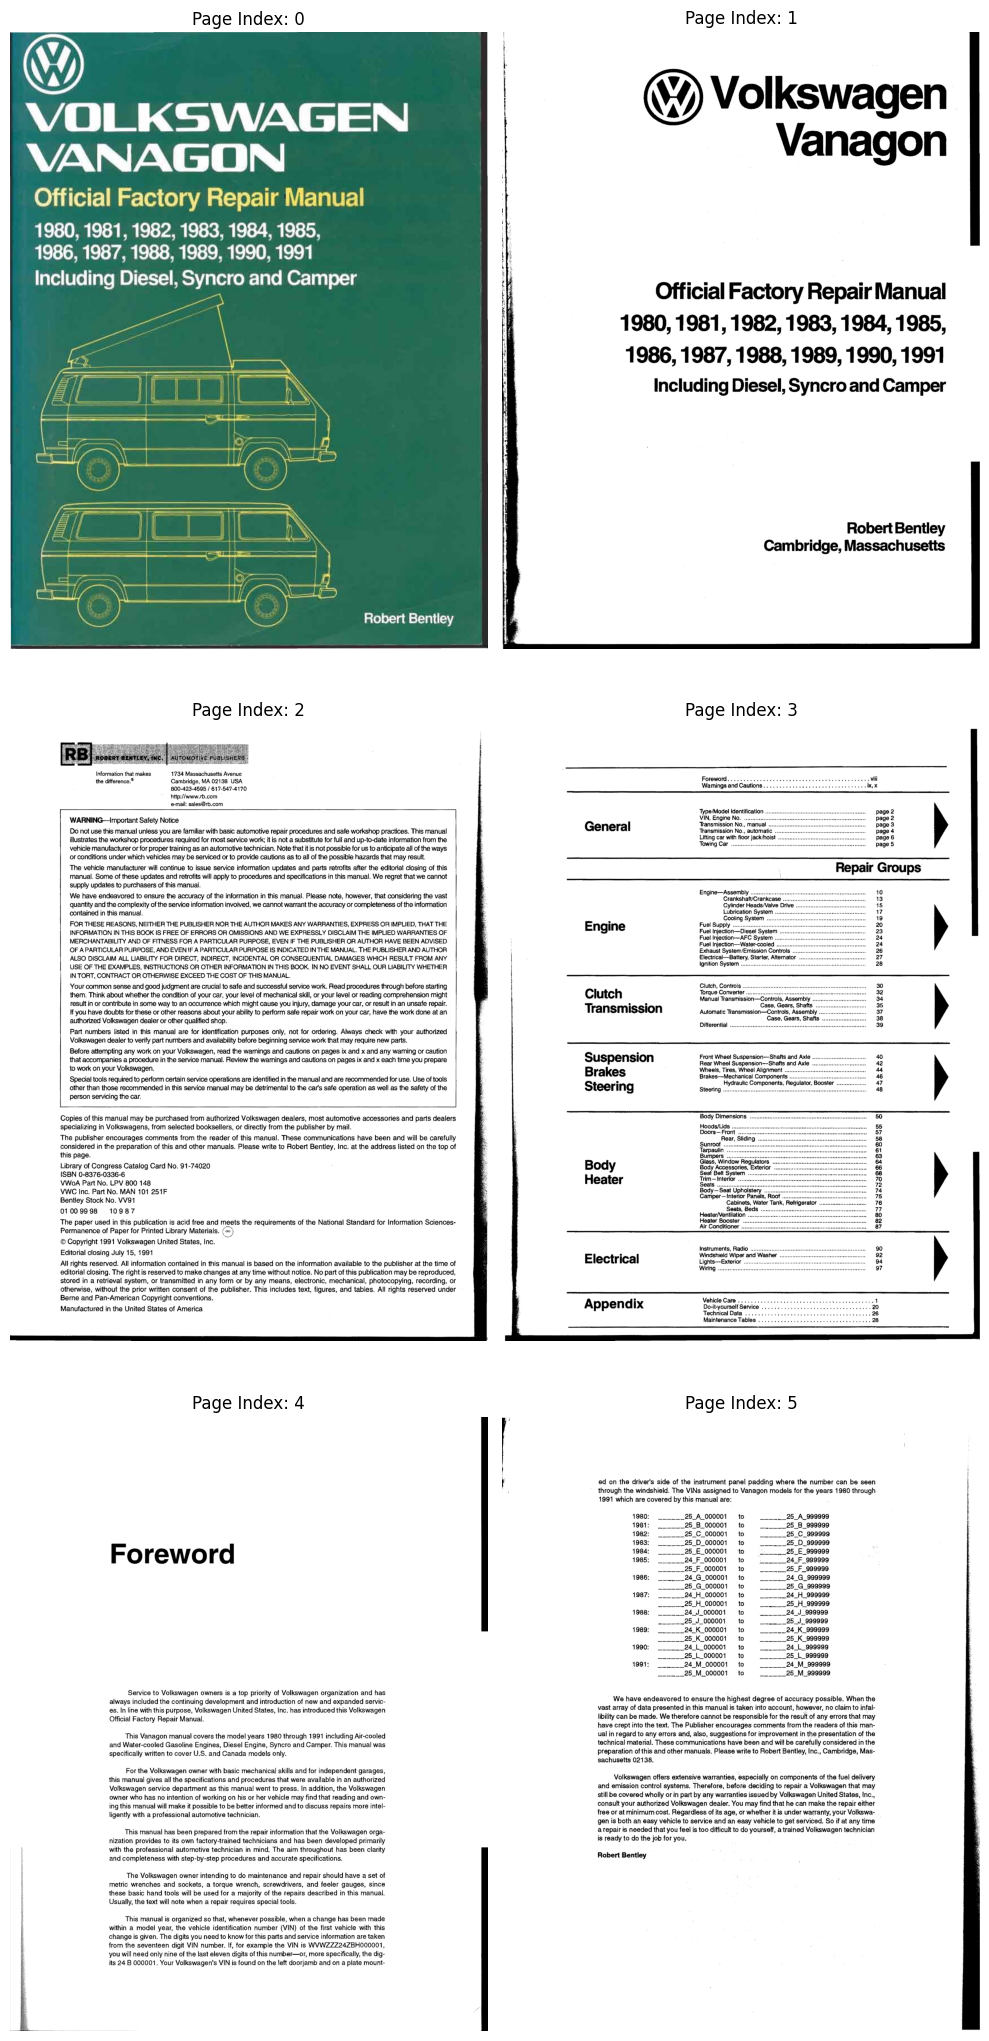

In [33]:
# Add pages numbers to page images
transformed_pages = add_page_numbers_to_images_preview(pages)

# Preview the first 5 pages (or any subset you like)
sample_indexes = [0, 1, 2, 3, 4, 5]  # Change this to preview specific pages
display_selected_pages(transformed_pages, sample_indexes, columns=2)


In [35]:
# Upload pages, save file names
import tempfile

uploaded_file_names = []

with tempfile.TemporaryDirectory() as temp_dir:
    for i, page in enumerate(transformed_pages):
        image_path = f'{temp_dir}/page_{i + 1}.jpg'
        page.save(image_path, 'JPEG')

        uploaded_file = genai.upload_file(image_path)
        # print(f"Uploaded file: {uploaded_file}") # for debugging
        uploaded_file_names.append(uploaded_file.name)
        
# print('Uploaded file URIs:', uploaded_file_uris) # for debugging

# INTERNAL NOTE - no cost to upload files, stored for 48h

In [36]:
# Retrieve uploaded files
uploaded_files = [genai.get_file(filename) for filename in uploaded_file_names]

In [38]:
# Cache context
from google.generativeai import caching
import datetime
import time

cache = caching.CachedContent.create(
    model='models/gemini-1.5-pro-002',
    display_name='manual 130',
    system_instruction=(
        'You are an expert in machine repair using manuals, and your job is to answer'
        'the user\'s query based on the images of machine manual pages you have access to.'
        'Ensure your answer is detailed and directly references relevant instructions from the manual.'
        'The page number is at the bottom of the file, prefixed with the string ACTUAL PAGE NUMBER.'
    ),
    contents=uploaded_files,
    ttl=datetime.timedelta(hours=2),
)

In [39]:
# Construct model that uses caching
model = genai.GenerativeModel.from_cached_content(cached_content=cache)

In [42]:
# Function - extracts page numbers from model response
import json

def extract_page_numbers(response):
    """
    Extracts page numbers from the response.

    Args:
        response (GenerateContentResponse): The response containing relevant page numbers.

    Returns:
        list: A list of zero-based page indexes.
    """
    try:
        # Extract the JSON string from the response content
        json_string = response.candidates[0].content.parts[0].text
        response_data = json.loads(json_string)
        
        # Extract relevant pages
        relevant_pages = response_data.get("relevant_pages", [])
        
        # Convert manual page numbers to zero-based indexes
        page_numbers = [int(page["manual_page_num"]) - 1 for page in relevant_pages]
        answer = response_data.get("query_answer")
        return page_numbers, answer
    except (KeyError, json.JSONDecodeError) as e:
        print(f"Error extracting page numbers: {e}")
        return []


Instructions for towing your Vanagon can be found on pages 6-7.


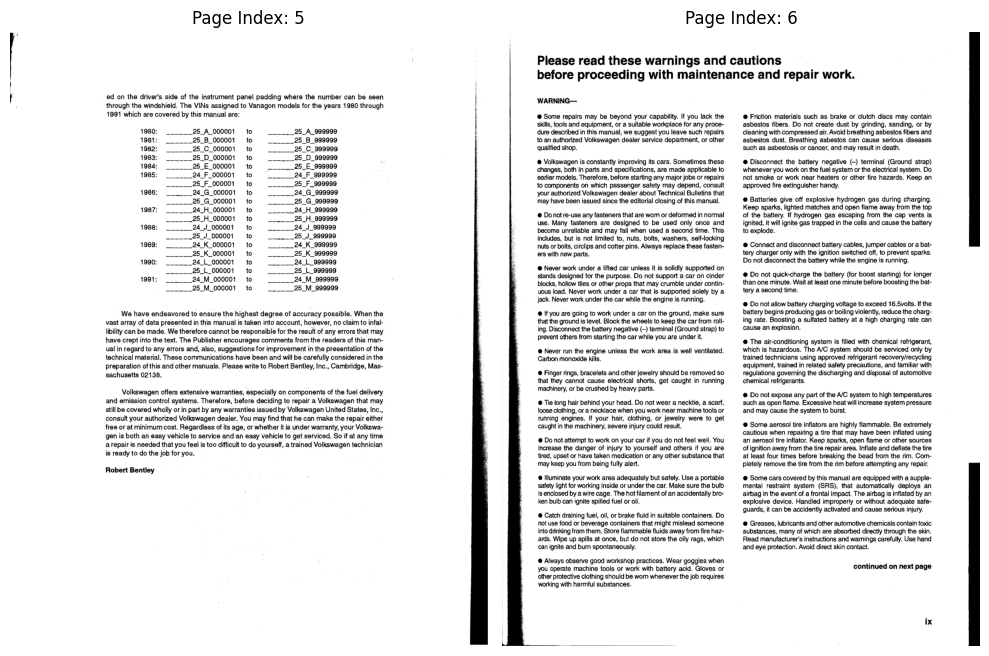

In [46]:
# Query 1
query = "Where can I find information on towing?"

response = model.generate_content(
    [
        (query)],
    generation_config=genai.GenerationConfig(
        response_mime_type="application/json",
        response_schema=Response
    ),
)
page_nums, answer = extract_page_numbers(response)
print(answer)
display_selected_pages(pages, page_nums)

# Correct answer, wrong display 
# (page 6 and 7 of the manual's index, but LLM doesn't know pdf index of these pages yet)

In [47]:
# Query 2a
query = "What are the steps to adjusting the hydraulic valve lifters?"

response = model.generate_content(
    [
        (query)],
    generation_config=genai.GenerationConfig(
        response_mime_type="application/json",
        response_schema=Response
    ),
)
page_nums, answer = extract_page_numbers(response)
print(answer)
display_selected_pages(pages, page_nums)

# The answer is on page 127 & 128. Page 127 has the name of the procedure with some notes, page 128 has the steps.
# For the error below, '15.23' is how the manual says page 23 of section 15 (aka page 127), again just an issue with LLM not seeing pdf indexed page num.
# Should also be 15.24 aka page 128.

# I printed out the model's answer below, it is mostly correct, though missing a step or two. Should see about reducing temperature or prompting not to summarize steps.

ValueError: invalid literal for int() with base 10: '15.23'

In [50]:
# Query 2a answer
json_string = response.candidates[0].content.parts[0].text
response_data = json.loads(json_string)
answer = response_data.get("query_answer")

print(answer)

To adjust the hydraulic valve lifters:
1. Turn adjusting screws in rocker arms so that all adjusting screws and valve stems have clearance.
2. Turn crankshaft until cylinder No.1 is at TDC.
3. Turn adjusting screws clockwise until they just contact valve stems.
4. Rotate crankshaft 180° and adjust next cylinder.
Repeat until all cylinders have been adjusted.  This information is from page 15.23


In [51]:
# Query 2b
query = "Show me the exploded schematic for the drive belt cover."

response = model.generate_content(
    [
        (query)],
    generation_config=genai.GenerationConfig(
        response_mime_type="application/json",
        response_schema=Response
    ),
)
page_nums, answer = extract_page_numbers(response)
print(answer)
display_selected_pages(pages, page_nums)

# 13-79 refers to the image id 13-790 which is the correct exploded schematic, so the model successfully gets it!
# see print statement below

ValueError: invalid literal for int() with base 10: '13-79'

In [52]:
# Query 2b answer
json_string = response.candidates[0].content.parts[0].text
response_data = json.loads(json_string)
answer = response_data.get("query_answer")

print(answer)

None


In [53]:
# Query 2b full response
print(response)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "{\"relevant_pages\": [{\"image_file_name\": \"13.21a.png\", \"information_segements\": [{\"contributing_information\": \"Figure 13-78 shows an exploded view of the fully closed drive belt cover.\", \"contributing_information_type\": \"text\"}, {\"contributing_information\": \"The drive belt cover has two parts, an upper and a lower.\", \"contributing_information_type\": \"text\"}], \"manual_page_num\": \"13-79\"}, {\"image_file_name\": \"13.20.png\", \"information_segements\": [{\"contributing_information\": \"Figure 13-76 exploded view of the older two part drive belt cover on a diesel engine.\", \"contributing_information_type\": \"text\"}], \"manual_page_num\": \"13-78\"}]}"
              }
            ],
            "role": "model"
          },
         

In [54]:
# Query 3
query = "What is the part number for a valve adjusting disc with thickness 3.40?"

response = model.generate_content(
    [
        (query)],
    generation_config=genai.GenerationConfig(
        response_mime_type="application/json",
        response_schema=Response
    ),
)
page_nums, answer = extract_page_numbers(response)
print(answer)
display_selected_pages(pages, page_nums)

"""
Query: "What is the part number for a valve adjusting disc with thickness 3.40?"
Location: page 114
Answer: 056 109 563
"""

# Answer is incorrect, that is part number for thickness 4.00. Inclear if model found correct page.
# If did find correct page, could be issue parsing text from the table.

The part number for a valve adjusting disc with thickness 3.40 is 056 109 575
Some indexes are invalid and have been skipped: {611}


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

In [55]:
# Query 3 full response
print(response)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "{\"query_answer\": \"The part number for a valve adjusting disc with thickness 3.40 is 056 109 575\", \"relevant_pages\": [{\"image_file_name\": \"bentley_vanagon_official_factory_repair_manual_1980-1991_pg_612.jpg\", \"information_segements\": [{\"contributing_information\": \"Thick-\\nness\", \"contributing_information_type\": \"table\"}, {\"contributing_information\": \"3.40\", \"contributing_information_type\": \"table\"}, {\"contributing_information\": \"056 109 575\", \"contributing_information_type\": \"table\"}], \"manual_page_num\": \"612\"}]}"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "avg_logprobs": -0.13260982023271103
        }
      ],
      "usage_metadata": {
        "

In [40]:
response = model.generate_content(
    [
        ("What is the engine code for a 4 speed manual transition?")],
    generation_config=genai.GenerationConfig(
        response_mime_type="application/json",
        response_schema=Response
    ),
)
print(response)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "{\"query_answer\": \"The engine code for a 1980-1991 Vanagon with a 4-speed manual transmission and 2.0 liter air-cooled engine is CV.\", \"relevant_pages\": [{\"image_file_name\": \"bentley_vanagon_0001.jpg\", \"information_segements\": [], \"manual_page_num\": \"1\"}, {\"image_file_name\": \"bentley_vanagon_0002.jpg\", \"information_segements\": [], \"manual_page_num\": \"2\"}, {\"image_file_name\": \"bentley_vanagon_0021.jpg\", \"information_segements\": [], \"manual_page_num\": \"21\"}]}"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "avg_logprobs": -0.06448320857065167
        }
      ],
      "usage_metadata": {
        "prompt_token_count": 35170,
        "candidates_token_count": 

In [43]:
page_nums, answer = extract_page_numbers(response)
print(page_nums)
print(response)

[0, 1, 20]
response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "{\"query_answer\": \"The engine code for a 1980-1991 Vanagon with a 4-speed manual transmission and 2.0 liter air-cooled engine is CV.\", \"relevant_pages\": [{\"image_file_name\": \"bentley_vanagon_0001.jpg\", \"information_segements\": [], \"manual_page_num\": \"1\"}, {\"image_file_name\": \"bentley_vanagon_0002.jpg\", \"information_segements\": [], \"manual_page_num\": \"2\"}, {\"image_file_name\": \"bentley_vanagon_0021.jpg\", \"information_segements\": [], \"manual_page_num\": \"21\"}]}"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "avg_logprobs": -0.06448320857065167
        }
      ],
      "usage_metadata": {
        "prompt_token_count": 35170,
        "candidates_tok

The engine code for a 1980-1991 Vanagon with a 4-speed manual transmission and 2.0 liter air-cooled engine is CV.


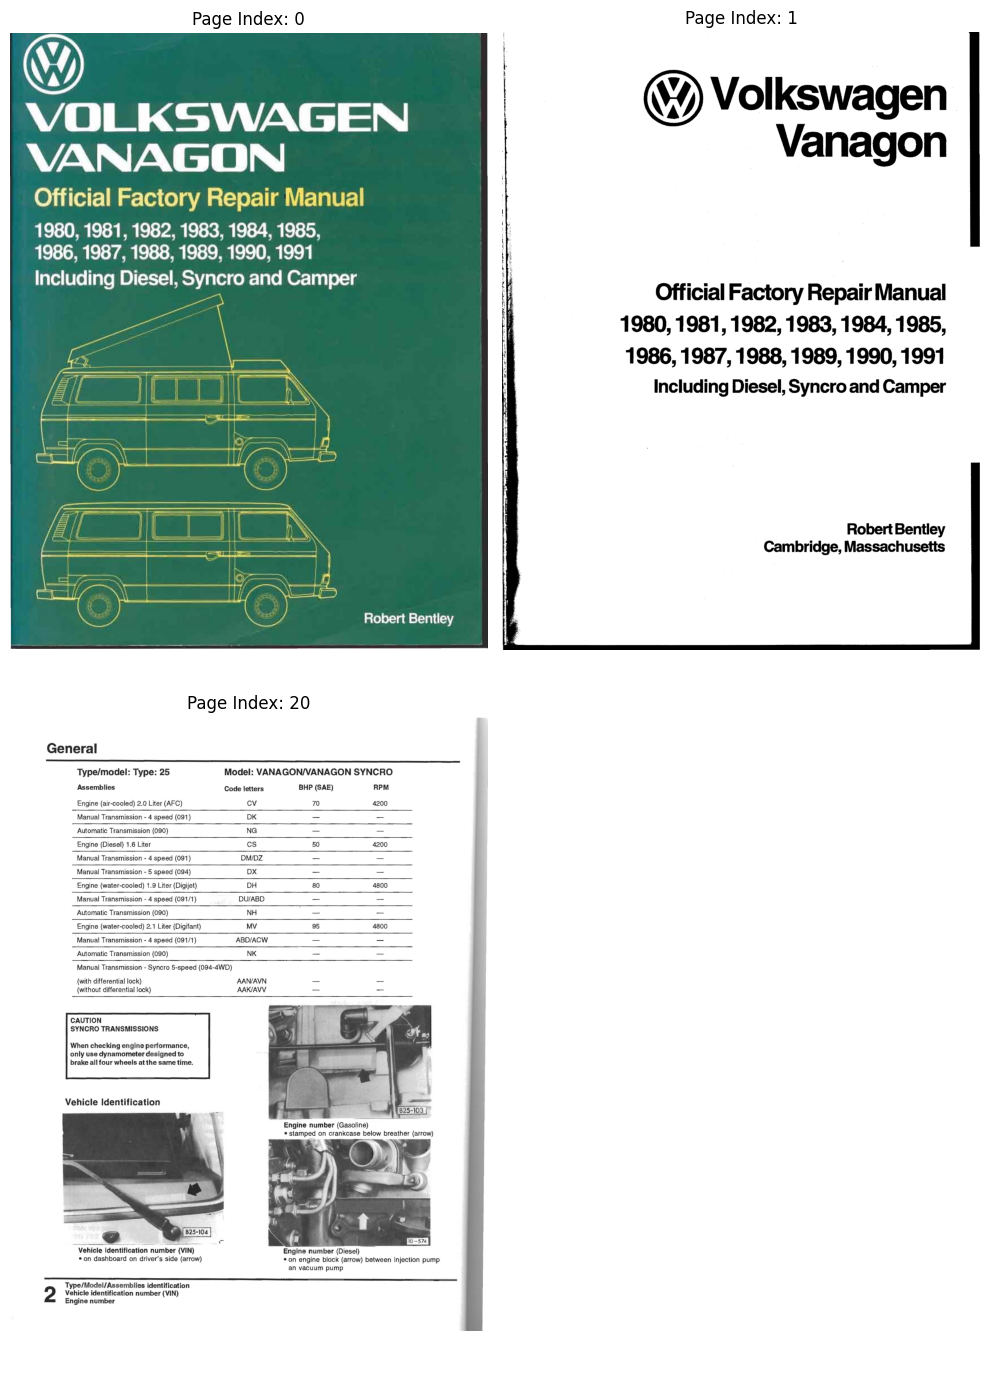

In [44]:
print(answer)
display_selected_pages(pages, page_nums)

In [45]:
# Usage & costing stats
import pandas as pd

caching_cost_per_million = 4.5
cached_cost_per_million = 0.625
non_cached_cost_per_million = 2.5
output_cost_per_million = 10

token_counts = response.usage_metadata

cached_tokens = token_counts.cached_content_token_count
output_tokens = token_counts.candidates_token_count
non_cached_tokens = token_counts.prompt_token_count - cached_tokens
total_tokens = token_counts.total_token_count

caching_cost_hourly = cached_tokens * 4.5 / 100000

cached_cost = cached_tokens * cached_cost_per_million / 1000000
non_cached_cost = non_cached_tokens * non_cached_cost_per_million / 1000000
output_cost = output_tokens * output_cost_per_million / 1000000
uncached_cost = (cached_tokens + non_cached_tokens) * non_cached_cost_per_million / 1000000

total_cost = cached_cost + non_cached_cost + output_cost

cost_table = pd.DataFrame({
    "Type": ['Cached', 'Non-cached', 'Output', 'Total'],
    "Cost (USD)": [cached_cost, non_cached_cost, output_cost, total_cost],
    "Tokens used": [cached_tokens, non_cached_tokens, output_tokens, total_tokens]
})

cost_table.set_index("Type", inplace=True)

print('Cached costs:')
print(f'  Cost per cached query run is ${round(total_cost, 2)} USD.') 
print(f'  Cost per hour of caching is ${round(caching_cost_hourly, 2)} USD')
print('\n')
print('Uncached costs:')
print(f'  Cost per query run without caching is ${round(uncached_cost + output_cost, 2)} USD')
print('\n')
print(f'Cost table: \n{cost_table}')

Cached costs:
  Cost per cached query run is $0.02 USD.
  Cost per hour of caching is $1.58 USD


Uncached costs:
  Cost per query run without caching is $0.09 USD


Cost table: 
            Cost (USD)  Tokens used
Type                               
Cached        0.021972        35156
Non-cached    0.000035           14
Output        0.001670          167
Total         0.023678        35337


In [ ]:
# Basic UI
'''
How to:
Edit the question below with what you want to know, then run the cell for your answer.

Example questions:
Finding certain pages - "Where can I find information on installing the engine?"
Getting specific answers - "What are the torque values for installing the engine?"
Understanding - "How do I install the engine?"
General questions - "What is this document about?"

Note: Some questions can't be answered using information from the manual.
This could be because the question is unrelated, like "Is Taylor Swift going to keep making bangers?"
It could also be because you expected the information to be in the manual, but it isn't. 
For example, "How could I link a solar system to the existing electrical?"
For these situations, the tool will let you know that the manual doesn't have relevant information.
'''

# Edit me!
question = "Where do I find information on towing?"

# Don't touch!
generate_response(question)

In [ ]:
# Query Types
"""
The tool should be able to answer 3 types of queries (find information, return information of certain format, return a detail).
Each answer should also display relevant page(s).

3 query types:
    1 - "Where can I find information on X" (where X is a topic) - The answer points to single or multiple pages
    
    2a - "What is the procedure for... " (where ... is e.g. removing the engine, bleeding the break fluid, etc.) - The answer gives the steps
    2b - "Show me the exploded schematic for Y" (where Y is a composite part) - The answer points to the page(s) with the schematic
    2c - "How do I troubleshoot X" (where X is ...) - The answer points to the page(s) with the troubleshooting flow chart / table
    2d - "Get the circuit diagram from X" (where X is ...) - The answer points to the page(s) with the circuit diagram
    
    3 - [Asks for a detail] (e.g. What is the winter tire tread depth) - The answer is the detail

Type 1 and type 3 questions are data-format agnostic - they don't care if the information comes from text, tables, diagrams, etc.

Type 2 questions are grouped together because in all cases the user is seeking a specific data-format. 
The manual uses different formats for different purposes.
For example, steps to do something are in text, visuals of how everything fits together are in exploded schematics, etc.
A technician might want to know the steps of a procedure, or remember how parts connect, or review the troubleshooting workflow.

While I listed 2a-2d, if our MVP just returned 2a & 2b that would cover most of the use.
The manual also contains other data-formats: data-sheets, layout diagrams, simple diagrams, index tables, graphs, and testing tables, 
but these are less frequent than the data formats in 2a-2d, so we omit them for this demo.
"""

# Queries in first 130 pages
"""
1
Query: "Where can I find information on towing?"
Location: page 27, 28
Answer: N/A

2a
Query: "What are the steps to adjusting the hydraulic valve lifters?"
Location: page 133
Answer:
- back out adjusting screws in rocker arms until ball shaped end is flush with surface of arm
- turn crankshaft until cylinder No. 1 is at TDC
  - mark on rotor must be in line with mark on distributor housing
- turn adjusting screws in until they just touch valve stems
- turn adjusting screws 2 turns clockwise and tighen lock nuts
- rotate crankshaft 180° clockwise and adjust next cylinder
- repeat until all cylinders are adjusted

2b
Query: "Show me the exploded schematic for the drive belt cover."
Location: page 65
Answer: N/A

3
Query: "What is the part number for a valve adjusting disc with thickness 3.40?"
Location: page 114
Answer: 056 109 563
"""

# Extra Queries / Queries from the full manual
"""
2a
Query: "What are the steps to replacing the final drive oil seals?"
Location: page 565
Answer:
- detach drive shaft from flange
- place drip pan underneath 
- remove drive shaft flange
- pry out seal
- drive seal in until fully seated
- tighten drive flange bolt to 25 Nm (18 ft lb) and drive shaft mounting bolts to 45 Nm (33 ft lb)
- check transmission oil level and add if necessary

2a
Query: "What are the steps to removing the driveshaft on the syncro?"
Location: page 655
Answer:
- loosen mounting bolt of front final drive (arrow) Do NOT remove bolt
- loosen side bolts of front final drive mounting bracket (arrow) Do NOT remove bolts
- remove bolts (arrow) at front and rear driveshaft flanges and remove driveshaft

2b
Query: "Show me the exploded schematic of the exhaust system."
Location: page 288, 289
Answer: N/A

2b
Query: "Show me the exploded schematic of the starter."
Location: page 301
Answer: N/A

2b
Query: "Show me the exploded schematic of the ignition distributor with the Hall generator."
Location: page 353
Answer: N/A

2b
Query: "Show me the exploded schematic of the gear shift linkage for the 5-speed 094."
Location: page 398, 399
Answer: N/A

2b
Query: "Show me the exploded schematic of the output housing for the 4 wheel drive 094."
Location: page 527
Answer: N/A

2c
Query: "How do I troubleshoot the case where there's no voltage at injectors?"
Location: page 255
Answer: N/A

2c
Query: "How do I troubleshoot the ATF level?"
Location: page 563
Answer: N/A
563

2d
Query: "Show me the circuit diagram for the AC for a water-cooled digijet 1984" 
Location: page 1176
Answer: N/A

3
Query: "What tread depth do snow tires need?"
Location: page 1304
Answer: 5/32 in / 4mm

3
Query: "How often should I inspect my tires?
Location: page 1302
Answer: Every 2000 miles / 3000 kilometers

"""

In [ ]:
# INTERNAL - Ideal outputs by query type (types are outdated, but response format isn't)

# Case 1 - User wants to know location of information

# 1a - Result is on a single page
# Example query
"""
Where can I find information on engine codes?
"""
# Example response
"""
That information is in a table (alt:[is in a diagram / comes from the text]) on page 20. 

Here is the page for your reference:
[displays page]

"""

# 1b - Result is from multiple pages
# Example query
"""
Where can I find information on towing?
"""
# Example response
"""
That information is in several places in the manual. 

Below I've listed each place by its page number, and why it is relevant.

Locations:
- Page 27: discusses emergency towing and towing speed/distance for front hookups
- Page 28: disccesses towing speed/distance for rear hookups and flat towing

Here are the pages of the manual for your reference:
[displays first page]
[some mechanism to change what page viewed - toggle, or maybe just 'next page', Evan's discretion]

"""

# Case 2 - User wants to know information located in the manual

# 2a - Single page answer
# Example query
"""
What is the engine code for a 5 speed manual transition?
"""
# Example response
"""
The engine code for a 4 speed manual transmission is DX.

This information is in a table on page 20. 

Here is the page for your reference:
[displays page]

"""
# 2b - Multi page answer
# Example query
"""
What are the torque values for engine installation?
"""
# Example response
"""
The torque values are different for each engine type. 

For the Air cooled engine, the values are.... 
For the diesel engine, the values are.... 
For the water-cooled engine, the values are....

That information is in several places in the manual. 

Below I've listed each place by its page number, and how it contributes to the answer.

Locations:
- Page 36: provides torque values for the air-cooled AFC engine
- Page 38: provides torque values for the diesel engine
- Page 41: provides torque values for the water-cooled engine


Here are the pages of the manual for your reference:
[displays first page]
[some mechanism to change what page viewed - toggle, or maybe just 'next page', Evan's discretion]

"""

In [ ]:
# Rough notes going through manual to identify query types
"""
To do with these notes:
- Description of how pages are laid out
- Description of data formats, with example pages
- Description of limitations of the pdf e.g. photocopy issues
- High level important features of the manual - e.g. half of info is visual

# handling different engine types, years, canada/us

# "How do I do an oil change?"
# "What are the steps to removing the Air-cooled AFC engine?"
# "Are there any warnings I should know about working on the valve drive?"
# how do i do an engine oil check? p.1293 - lists steps
# how many amps is the fuse for the radiator cooling fan? p.1239, a: 30
# what track is the left rear speaker on? p.1235, a: track 6 of the circuit diagram
# how many ground connections does the stereo radio have? p.1233, a: 1
# are there any pictures for checking the oil pump backlash? yes, p. 140
# what parts are required for replacing the coolant pipes? p.153, listed in table


Advanced query types (not going to try for): still to write


at least half of the important information is visual
the manual is a photocopy, so data quality issues to manage expectations of perfect recall of information thats in it

These are the kinds of information in this manual: 
- Exploded schematics
- Procedures
- Troubleshooting flowcharts or tables
- Photographs
- Layout diagrams
- Simple diagrams
- Data tables
- Circuit diagrams
- Index pages
- Graphs
- Testing tables


almost want to make a list of the pages that are challenges in the doc, like
- the table with a diagram or graph in one of the cells
- the schematics split across two pages
- the circuit diagrams split across many pages
- the pages with margins cut off
- images set in proceedurs that are too dark from the scan

make guide that describes each kind of information, along with an image with a bounding box around that kind of information
points out the kind of information in it

This is what is within those different kinds of information
blah blah


i'm seeing something, is that noted in a schematic or described in a process?

the schematic is useful for seeing all the parts and how they go together
the steps are useful for doing the thing, often it is helpful to see the schemtic first
steps have photographs baked in, often it's photograph and the fig description is the step, and there's a subbullet of what to do
troubleshooting flowcharts are on the same level as procedures

the document is actually very visual, so pure text analysis or response might not be most helpful for someone fixing the thing
layout diagrams serve a similar purpose as exploded schematics - showing the system
simple diagrams are often complements to the process steps, not usually the whole system is shown
data tables feel separate from system diagrams AND procedures
circuit diagrams are also completely separate
indexes are just describe what content is in the section to follow, it doesn't have information beyond giving navigation

in scope - being able to display the relevant information kind for a specific part or procedure - returning the page that has that kind in it
meta questions about how to understand how information is organized in the document - this i can write up and include as a system prompt or context
the procedures, diagrams, etc often split by vanagon version - engine type and year - could be getting user to specify this in the query, or just returning everything that would relate

advanced but not for our scope
- guiding user to a more specific query, like "these are the circuit diagrams available, which one would you like?"
- what are the different versions of this machine 
- are there any schematics of this thing? -> yes, here are a menu of them, which do you want to see?
- I'm hearing this noise, what should I check / what is wrong? - missing origin of noise to start
- filtering manual down to only one version "give me a version of the manual that only applies to the synchro"
- user describes a diagram they are looking for and the LLM finds it

out of scope because dumb
- how many exploded schematics are there in the document?
- question is too broad, coming from a novice, like "what parts does the van need", they are asked to be most specific, or guided in how to be specific

tools, parts, tolerances, torque values, part numbers, warnings, cautions, reusability

section describing how the manual is structured - for the model to understand, or repeat out if a user asks

this manual is effectively for a bunch of variations of a vanagon - varyign on one axis by engine type, on another by year, another on Canada/US, and a few other dimensions
the biggest differences is with enginge type - where the configuration or electrical circuits are so different than the type for a vehicle system is in a separate chapter
whereas sometimes the difference is just a note on different torque specs - like the brake systems are all quite similar

"""

# Case 3 - 





# p.445 - table with a diagram in a cell


# some steps are adjusting, some are checking, installing, sealing, bleeding, replacing, resealing, adjusting - subsystem, working verb


"What are the steps to doing X"
# I am inspecting part X, what should I be looking for?

# One level of summary from a process
# "When doing job X, what parts can be reused and what parts always have to be replaced"
# "How do I know if Part X needs to be replaced"

# specifications - questions about a detail
# "What tool do I need for doing job X"
# Person is trying to make sense of what they see - colors, stamps
    # "What do the color codes on the crankshaft mean?"

# 

# find and return information type
# "Show me all the index pages"
# "Are there any exploded schematics of the engine?"
# "Where can I find an exploded schematic of X"

# Comparing steps - not too useful
# "How are the steps for removing the Diesel engine different than the Air-cooled AFC engine?"

# General - What are all the different versions of vanagon covered in this manual?
# General - "How many exploded schematics are there in this manual"
# General - What are all the different actions I can take on the engine? (list of subsystem+verbs, e.g. removing the engine, installing the enginge, resealing the values, ...)


# Questions where the person is trying to make sense of the manual
# "How is information displayed in this manual" -> "text, tables, pictures, drawings, exploded schematics"
# "How is the manual structured" -> into chapters and subsections, top of each page is the section number and section title, bottom of each page
# is a quasi page number which is the section number followed by section indexed page number or letter, sometimes a second page number like E-5, 
# the version of vanagon the content is about enclosed in a box, and a list of topics covered on that page
# "What does a work sequence mean" -> this is how the manual refers to the steps involved in doing something, those steps are the work sequence - also called work procedure
# steps, rules, specifications, pre-conditions, tools


# "How do I figure out what version of vanagon I have?"

# "I am hearing noise Y, what should I be thinking about" - probably can't be covered, the information in the manual probably cant be diagnosing problems

# Finding certain pages - "Where can I find information on installing the engine?"
# Getting specific answers - "What are the torque values for installing the engine?"
# Understanding - "How do I install the engine?"
# General questions - "What is this document about?"


# how the manual organizes information, what medium different information is in
# 

# give me all the pages that only apply to syncro model
# where is this part in a circuit diagram

# exploded schematic, circuit diagram, layout diagram, labelled photographs, text, tables, troubleshooting flow charts (p.300), warning & caution boxes
# every exploded schamtic, photograph, diagram, has an ID in a box within it in the bottom right
# some tables are technical data
# some pages are indexes
# some graphs p.245
# some tables which are testing steps - each row is a step in the test p.278

# exploded schematics often list torque values for simple parts like nuts, screws, or label the part with its name

# if no box in the bottom, can assume information applies to all versions, unless text or diagrams make distinction there

# dont think it will be able to go from "i hear this" to "this is the problem" unless they're specific about the part they're seeing

# electrical sections have a list of items in the circuit and what track they are on, what the wire connector are, and the group connections
# then has circuit diagrams, then has page of the fuse arrangement
# where can i find a legend of the symbols used in the wiring diagram? p.1031

# section 97 has sevreral indexes, one for each type of vanagon - aircooled, water-coooled, diesel

# DIY section has different stle of header and footer

# could do troubleshooting windsheild wiper bad patterns - not clean, leaving streaks, only working on one side

# p 999 has troubleshooting flow diagram spanning multiple pages


# maybe put brakes on queries where they are asking too braod questions like "what parts does the van need", "list all the parts that need to be replaced when working on anything in the van"

# could be helpful to have selection of model of vanagon - year, aircooled/watercooled/diesel, canada/us

# person can describe a diagram they are looking for, it can bring up the right one or some candidates

# 171-172 - exploded schematic takes up whole page, 179-180 same thing, 292-293 too for a split battery

# basic usefulness is displaying the right pages - especially to see exploded schematics, circuit diagrams, pictures

# steps usually have pictures called figs in them, baked into the work sequence to follow 
# purpose of schematic is for person to see all the parts, and how they fit together, or where they are relative to each other
# from there maybe they can follow the steps in a sequence more easily?

# p190 "never smoke when working with fuel" LMAO

# "What are the rules of cleanliness when working on the fuel system?"

# would the model do better if it knew that the versions of the machine were in boxes at the bottom of a page?

# manual is not perfect copy of the original, some pages duplicated (p204&205), some sections missing entirely
# some pages cut off and on next page - so missing those toque values e.g. p214/215

# an index page - listing machine subsections by vanagon version, with each version alphabetical, and listed with the part name, and optionally verbs of working on it e.g. installing, bleeding

# I want to do something, and my vehicle type is this - gets them to the right pages that then describe the steps
# steps are as text, often with a photograph inserted inline with the steps, with the fig name describing what to do, or labelled with the parts that were labelled in the step descriptions

# maybe we give up on types of questions where somehow composit of multiple sections - multiple positivielies is fine, or an answer that spans across multiple concurrent pages
# but not of combining one system with another interms of question - i don't know those questions to ask

# can return technical data sheet
    # give correct answer of technical data from that sheet
# can return an exploded scematic
    # torque values, bolt specs from in that
    # naming the part based on the user description
    # whether it needs to be replaced
# can return a circuit diagram
# can return a process e.g. removing, checking
    # parts needed, tools needed, warnings/cautions
    # format nicely as steps, warnings, notes
    # flag when the user should look at the page because it uses diagrams
# can return a troulebhooting flow

# p.445 LOL a table that has diagrams IN it

# returns the above based on spec of vanagon type and year

# maybe questions are from technician that knows what thing they're trying to do, not novice who would ask questions that are too broad
# not in this version, prompting user to get more specific for when there are many possible answers, or ordering pages based on their probability of being relevant

# p.563 - good simple example of troubleshooting flow diagram

# exploded schematic also sometimes indicates what fig relates to a cettain process e.g. assembling

# best if it could take their question, then present the subtype options that matter for that section of the manual

# p.769 - troubleshooting as a table rather than flow
# p.941 - troubeshooting as a different kind of table, only 2 of these in the manual

In [ ]:
# Competition requirement - Notebook
# Demonstrate how to process inputs greater than 100,000 tokens

# How many tokens does our use case use?
# Context alone uses ~1300 pages.
# Each page is given as an image, which google considers 258 tokens.
# Total: 335,400 tokens

In [ ]:
# Competition requirement - Notebook
# Discuss why being able to process large inputs was helpful for the selected use case

In [ ]:
# Competition requirement - Video
# Summarizes the notebook

# Planned video flow
"""
PROJECT MOTIVATION (1.5 min) - talking to camera
DEMONSTRATE OUTPUT (1 min) - screen record with voice-over
SUMMARIZE NOTEBOOK (1 min) - screen record with voice-over
CONCLUSION - talking to camera
"""

In [ ]:
# PROJECT MOTIVATION
"""
Probably cut - Place of AI, especially LLMs, in manufacturing:
    - AI used widely, lagging in manufacturing
    - adoption focused on CV, time series - robots, automation, predicting maintenance
    - limited LLM
    - thinking goes on factory floor, its about seeing and hearing things, rather than talking or reading

Problem we're solving:
    - when machine breaks, technician comes in (opt i'm in factory, point to machine behind)
    - faster they can fix the machine, faster factory can produce products and make profit
    - machine manuals can be thousands of pages, and a fix could involve several manuals (broll, thick manuals)
    - could an LLM help technicians find relevant information faster, fixing the machine faster (standing in factory, holding a tablet)
    - answer might not be on one page, or might be in a table or diagram, so a simple ctrl+F won't do (screen record, show page with diagram, table)

Why gemini / long-context:
    - previously working on RAG pipeline to solve this, then google came out with gemini long context (leaving building, vlogger walk in parking lot)
    - could we use this to simplify the codebase and still be performant? (stop walking)

Our special demo:
    - we demo this with the volkwagen vanagon offical factory repair manual (van in parking lot, image of manual overlaid)
    - I own a vanagon and tried out vanlife, involves a lot of breakdowns and fixes (sitting in van, turn on for stutter)
    - lot of people out there helped by a faster way to trouble shoot (drone of driving, grid of parked vans, dashcam of me driving)
    - so seemed like a good demonstration:
        - relatable to everyone, and 
        - still relevant to fixing machine breakdowns using thick machine manuals

that's enough context, lets try out the tool (van trunk open, sitting with laptop)
"""

In [ ]:
# DEMONSTRATE OUTPUT
"""
now we're in the notebook's UI block

lets try different queries a user might have

simplest is finding the page or pages for information I want

[desribe output - gives the pages and displays the page]

next can get an answer based on information in those pages, see it still returns the page references

[describe output - similar to page, but first answers the question, the displays the pages so you can be confident in the answer]

advanced is asking for explanations based on the information

[describe output - twe it is useful answer]

and for coverage, can handle general questions about the manual or the machine themselves

[probably minimal to describe about output]

last, handles cases where the information isn't in the manual

[could skip, but comment is just "it will say the manual doesn't have that information]

So that's what it can do so far, how does it do that? Let's summarize the notebook

"""

# Discuss limitations of output?
# expected limits - handling questions about diagrams, maybe information in tables

In [ ]:
# SUMMARIZE NOTEBOOK
"""
So now we're at the top of the notebook, lets go through the code

First we run our installations, and imports, and configure the API
Then we convert the pdf to images and upload those to google using the AI upload API, saving the file names
Next we define our main function that takes a user question and generates a response
Last, we have the simple UI we used that lets anyone test out the tool

Lets go into the main function
[write out summary once we have written than function]
- takes in pages as system context
- generates an answer that displays the relevant manual pages
- need confidence in the answers, this gives that an lets LLM confirm its work, reducing halucinations

Two helpful features of the code
- uses context caching - makes it faster for user responses and save token cost
- get structured output from gemini, what lets us fetch the page to display to the user

And that is it. we were surprised by how simple and easy to use google's AI apis were
and we were blown away at the performance of the outputs

The notebook also has sections that discuss why long context was useful for this application, 
give guidance on kind of questions users can ask
"""

In [ ]:
# CONCLUSION
"""
Next steps - we're going to build this out into a full code base (from van trunk)
Develop the UI, add tests, trial different machine manuals
Might make something for the vanlifers (camera in van, sliding door closes)
"""

In [ ]:
# KNOWN ISSUES

# when asking how to install the engine, it does not like it
"text": "The first page of the Foreword section indicates that this manual was written to cover repair procedures for Volkswagen Vanagons, but **does not include engine removal or installation procedures.** \n\nBefore you begin any work on your vehicle, please note the warnings on page ix of the manual. Automotive service and repair is a serious business. Consult a qualified Volkswagen mechanic if you require assistance with engine installation. \n"


In [ ]:
# Basic response generation
model = genai.GenerativeModel("gemini-1.5-pro")
result = model.generate_content(
    [
        *uploaded_files, 
        "\n\n", 
        "Where can I find information on the drive belt?"
    ]
)
print(f"{result.text=}")